# **Capital Deepening Dredging**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
Dredge_power = 700 #kW
Production_rate_clay = 1800 + 200/(1000-500)*(3000-1800) #m3/h
Production_rate_sand = 1800 + 200/(1000-500)*(3000-1800)
Production_rate_cemented = 400 + 200/(1000-500)*(700-400)

for soil_type, production_rate in zip(['clay', 'sand', 'cemented sand'], 
                                      [Production_rate_clay, Production_rate_sand, Production_rate_cemented]):
    print(f'Production rate of {soil_type}: {production_rate:.1f} m3/h')
    print(f'Maximum weekly production rate of {soil_type}: {production_rate*24*7:.1f} m3/week\n')

Production rate of clay: 2280.0 m3/h
Maximum weekly production rate of clay: 383040.0 m3/week

Production rate of sand: 2280.0 m3/h
Maximum weekly production rate of sand: 383040.0 m3/week

Production rate of cemented sand: 520.0 m3/h
Maximum weekly production rate of cemented sand: 87360.0 m3/week



**Transporting clay and cemented material using pipeline**

In [3]:
def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1

V_sand, B_top_sand = V_trench(B = 200,H = 3,phi = 30, L=750) 
V_clay, B_top_clay = V_trench(B = 200,H = 2,phi = 15, L=750)
V_cemented, B_top_cemented = V_trench(B = 200,H = 1.5,phi = 30, L=750)
print('Volume of sand:', round(V_sand,0) ,'m3, top width:', round(B_top_sand,0), 'm')
print('Volume of clay:', round(V_clay,0) ,'m3, top width:', round(B_top_clay,0), 'm')
print('Volume of cemented sand:', round(V_cemented,0) ,'m3, top width:', round(B_top_cemented,0), 'm \n')

Volume of sand: 461691.0 m3, top width: 210.0 m
Volume of clay: 311196.0 m3, top width: 215.0 m
Volume of cemented sand: 227923.0 m3, top width: 205.0 m 



In [4]:
Pipeline_capacity = Production_rate_clay *0.8
t_pipeline_discharge = V_clay*0.7 / Pipeline_capacity #hour
print('Time to discharge clay volume via pipeline:', round(t_pipeline_discharge,1), 'hours')
print('Days to discharge clay volume via pipeline:', round(t_pipeline_discharge/20,1), 'days')

Time to discharge clay volume via pipeline: 119.4 hours
Days to discharge clay volume via pipeline: 6.0 days


In [5]:
rho_mix = 1500
rho_water = 1025
rho_sand = 2000
rho_cemented = 2400
rho_clay = 1800
Barges_velocity = 7 #knots
distance = 11 #km
distance_LR = 1 #km
distance_MF = 1 #km
Barge_capacity = 2500 #m3
t_manouvering = 15 #minutes
t_discharge = 10 #minutes


# Clamshell
Clamshell_bucket_capacity = 20 #m3
Cycle_time_clamshell = 90/60 #seconds to minutes
efficiency_clamshell = 0.88
Productivity_clamshell = Clamshell_bucket_capacity*efficiency_clamshell / Cycle_time_clamshell * 60 #m3/h
t_discharge_clamshell = Barge_capacity/Productivity_clamshell #hours
print('Clamshell discharge time:', round(t_discharge_clamshell,1), 'hours\n')

time_sailing = distance_LR*1000/(Barges_velocity*0.514444*60) #minutes
print(f'Time sailing LR and MF area:', round(time_sailing,0), 'minutes\n')


sediment = ['Clay', 'Sand', 'Cemented']
production_rate = [Production_rate_clay, Production_rate_sand, Production_rate_cemented]
volume = [V_clay*0.3, V_sand, V_cemented]

for sediment, rho, prod, volume in zip(sediment,[rho_clay, rho_sand, rho_cemented], production_rate, volume):
    solid_percentage = (rho_mix - rho_water) / (rho - rho_water)
    mass_dry = prod * rho
    mass_mix = mass_dry / solid_percentage
    volume_mix = mass_mix / rho_mix
    Load_time = Barge_capacity*60 / volume_mix  # mins  <-- keep this here
    max_dredger_volume_per_hour = prod  # m3/hr of dry solids
    max_dredger_slurry_rate = max_dredger_volume_per_hour / solid_percentage  # m3/hr slurry
    Load_time_dredger = (Barge_capacity / max_dredger_slurry_rate) * 60  # minutes limited by CSD rate
    Load_time = max(Load_time, Load_time_dredger)


    if sediment == 'Cemented':
        t_cycle = 2*time_sailing + Load_time + t_discharge_clamshell*60 + t_manouvering
    else:
        t_cycle = 2*time_sailing + Load_time + t_discharge + t_manouvering

    volume_cycle = Barge_capacity* solid_percentage
    sediment_mass_cycle = volume_cycle * rho

    n_cycles = volume / volume_cycle
    no_barges_sand = 1
    no_barges_cemented = 2
    total_cycle_minutes = n_cycles * t_cycle
    total_working_hours = total_cycle_minutes / 60

    #Cutter head maintenance calculations
    inspection_interval_hours = 100           # inspect every 100 operating hours
    replacement_wear_fraction = 0.40            # replace after ~50% wear
    teeth_per_head = 10                         # Beaver 65 typical
    downtime_per_tooth = 0.5                    # hours per tooth (~30 min)

    total_replacements = total_working_hours / (inspection_interval_hours / replacement_wear_fraction)
    replacement_downtime_hours = total_replacements * teeth_per_head * downtime_per_tooth

    adjusted_total_working_hours = total_working_hours + replacement_downtime_hours

    # cutting_time_h = volume_cycle / max_dredger_volume_per_hour    # hours spent cutting per cycle
    # cycle_time_h = t_cycle / 60.0                                  # total cycle time in hours

    # cutter_efficiency = cutting_time_h/ cycle_time_h


    print(f'{sediment}:')
    print('For soil density of', rho, 'kg/m3, loading and cycle time is', round(Load_time,1),'&', round(t_cycle,1),'minutes')
    print(f"Sediment volume per cycle: {volume_cycle:.0f} m³")
    print(f'total_cycle_minutes: {t_cycle:.0f} minutes')
    print(f"total_working_hours: {total_working_hours:.1f} hours")
    print(f'total cycles required : {n_cycles:.0f} cycles')
    # print(f'Cutting time per cycle: {cutting_time_h:.2f} h')
    # # print(f'Cutter efficiency: {cutter_efficiency:.3f} ({cutter_efficiency*100:.1f}%)')


    if sediment == 'Cemented':
        total_days = adjusted_total_working_hours / (20 * no_barges_cemented)
        print(f'Deployed barges: {no_barges_cemented}')
        print(f'Total days required : {total_days:.1f} days')
        total_weeks = total_days/7
        print(f'Total weeks required : {total_weeks:.1f} weeks\n')

    elif sediment == 'Clay':
        total_days_barges = (adjusted_total_working_hours / (20 * no_barges_sand))
        total_days = total_days_barges + (t_pipeline_discharge/20)
        print(f'Deployed barges: {no_barges_sand}')
        print(f'Total days for barges required : {total_days_barges:.1f} days')
        print(f'Total days including pipeline discharge: {total_days:.1f} days')
        total_weeks = total_days/7
        print(f'Total weeks required : {total_weeks:.1f} weeks\n')
        
    else:
        total_days = adjusted_total_working_hours / (20 * no_barges_sand)
        print(f'Deployed barges: {no_barges_sand}')
        print(f'Total days required : {total_days:.1f} days')
        total_weeks = total_days/7
        print(f'Total weeks required : {total_weeks:.1f} weeks\n')
   



Clamshell discharge time: 3.6 hours

Time sailing LR and MF area: 5.0 minutes

Clay:
For soil density of 1800 kg/m3, loading and cycle time is 40.3 & 74.6 minutes
Sediment volume per cycle: 1532 m³
total_cycle_minutes: 75 minutes
total_working_hours: 75.7 hours
total cycles required : 61 cycles
Deployed barges: 1
Total days for barges required : 3.9 days
Total days including pipeline discharge: 9.8 days
Total weeks required : 1.4 weeks

Sand:
For soil density of 2000 kg/m3, loading and cycle time is 32.1 & 66.3 minutes
Sediment volume per cycle: 1218 m³
total_cycle_minutes: 66 minutes
total_working_hours: 418.9 hours
total cycles required : 379 cycles
Deployed barges: 1
Total days required : 21.4 days
Total weeks required : 3.1 weeks

Cemented:
For soil density of 2400 kg/m3, loading and cycle time is 99.7 & 337.0 minutes
Sediment volume per cycle: 864 m³
total_cycle_minutes: 337 minutes
total_working_hours: 1482.2 hours
total cycles required : 264 cycles
Deployed barges: 2
Total days 

# **Calculation of cavitation**

Dillation (Delta n): 0.1471
Average permeability(k mean): 3.5e-06
The force P2 non cavitation: 37922.66 kN/m
The force P2 non cavitation: 37.92 MN/m

The average elevation (z mean): 9.0 m
The force P2: 76.42 kN/m
The force P2: 0.08 N/m 1e6
the lowest value will take place, so this situation will be cavitating


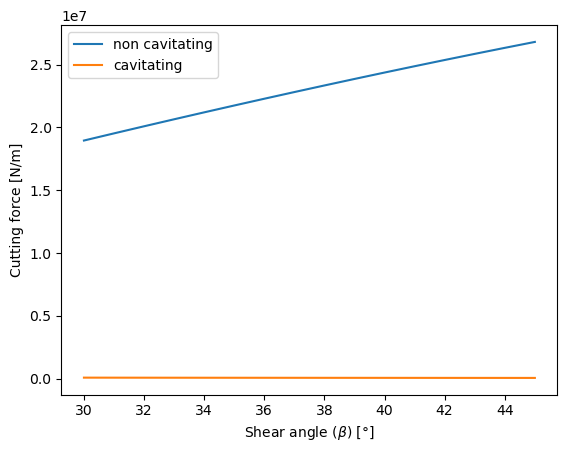

In [6]:
#CLAY
n0_cemented = 0.22
n1_cemented = 0.32
k0_cemented = 2 * 10**-6
k1_cemented = 5 * 10**-6
phi_cemented  = 30

v = 5 #m/s
h = 0.2 #m
alpha = 45 #deg
delta = 20 #deg

def calc_dn(n0_cemented,n1_cemented):
    return (n1_cemented-n0_cemented)/(1-n1_cemented)

print('Dillation (Delta n):', round(calc_dn(n0_cemented,n1_cemented),4))

def calc_k_mean(k0_cemented,k1_cemented):
    return (k0_cemented+k1_cemented)/2

k_mean = calc_k_mean(k0_cemented,k1_cemented)
print('Average permeability(k mean):', round(k_mean, 10))

def calc_p2_NO_cavitation(rho_w,b,h,v,k,delta_n):
    return 0.33*rho_w*9.81*b*h**2*(v/k)*delta_n

P2_NO_cavit = calc_p2_NO_cavitation(rho_w=1025,b=1,h=0.2,v=5,k=k_mean,delta_n = 0.2)
print('The force P2 non cavitation:', round(P2_NO_cavit/1e3, 2) , 'kN/m')
print('The force P2 non cavitation:', round(P2_NO_cavit/1e6, 2) , 'MN/m\n')

z1 = 8
z2 = 10
def calc_z_mean(z1,z2):
    return(z1+z2)/2

z_mean = calc_z_mean(z1,z2)
print('The average elevation (z mean):', z_mean , 'm')

def calc_P2_cavitation(rho_w,b,h,z,beta):
    beta_rad = beta*np.pi/180
    return rho_w*9.81*b*h*(z+10)/np.sin(beta_rad)

P2_cavit = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=30)

print('The force P2:',round(P2_cavit/1e3, 2) , 'kN/m')
print('The force P2:',round(P2_cavit/1e6, 2) , 'N/m 1e6')

P2_NO_cavit_serie = []
P2_cavit_serie = []

angle_serie = np.arange(30,45+1,1)

for beta in angle_serie:
    P2_NO_cavit_serie.append(calc_p2_NO_cavitation(rho_w=1025,b=1,h=0.2,v=5,k=k_mean,delta_n = 0.2)*np.sin(beta*np.pi/180))# multiply by angle in addition to formula
    P2_cavit_serie.append(calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=beta))


plt.plot(angle_serie, P2_NO_cavit_serie, label = 'non cavitating')
plt.plot(angle_serie, P2_cavit_serie, label = 'cavitating')
plt.legend();
plt.xlabel(r'Shear angle ($\beta$) [$\degree$]')
plt.ylabel('Cutting force [N/m]')

print('the lowest value will take place, so this situation will be cavitating')

The optimal angle: 33.8 degrees


<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Rifaamaliah\AppData\Local\Temp\ipykernel_9036\3720289618.py:20: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('shear angle (beta) [$\degree$]')


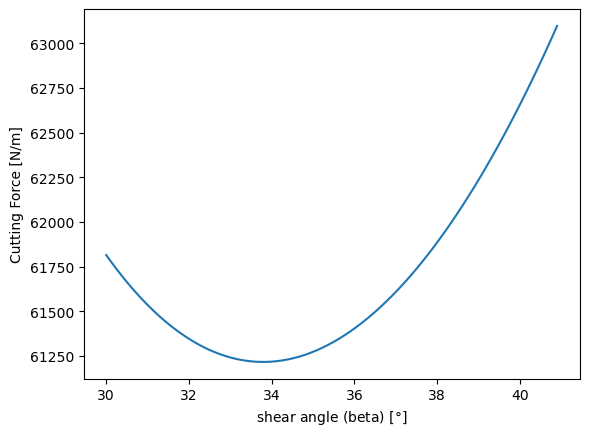

In [7]:
def calc_P1_cav(rho,b,h,alpha,z): # It follows the book, however the sugestion is that h should be h_blade, which influences the friction along the blade.
    return rho*9.81*b*h*(z+10)/np.sin(alpha*np.pi/180)

def calc_P2_cavitation(rho_w,b,h,z,beta): # used before, is correct
    beta_rad = beta*np.pi/180
    return rho_w*9.81*b*h*(z+10)/np.sin(beta_rad)

def calc_Fh(P1,P2,alpha,beta,delta,phi):
    return (P2*np.sin(phi*np.pi/180)*np.sin((alpha+delta)*np.pi/180)+P1*np.sin(delta*np.pi/180)*np.sin((beta+phi)*np.pi/180))/np.sin((alpha+beta+delta+phi)*np.pi/180)

beta_serie = np.arange(30,40+1,0.1)

Fh =[]
for beta in beta_serie:
    P1 = calc_P1_cav(rho = 1025,b=1,h=0.2,alpha=45, z = z_mean)
    P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=beta)
    Fh.append(calc_Fh(P1,P2,alpha=45,beta=beta,delta=delta,phi=phi_cemented))

plt.plot(beta_serie, Fh);
plt.xlabel('shear angle (beta) [$\degree$]')
plt.ylabel('Cutting Force [N/m]');

index_lowest = np.where(Fh == np.min(Fh))[0][0]
optimal_angle = beta_serie[index_lowest] 

print('The optimal angle:', round(optimal_angle,2), 'degrees')


In [8]:

def calc_Fv(P1,P2,alpha,beta,delta,phi):
    return (P2*np.sin(phi*np.pi/180)*np.cos((alpha+delta)*np.pi/180)-P1*np.sin(delta*np.pi/180)*np.cos((beta+phi)*np.pi/180))/np.sin((alpha+beta+delta+phi)*np.pi/180)

#Required cutting force
P1 = calc_P1_cav(rho = rho_sand,b=1,h=0.2,alpha=45, z = z_mean)
P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=optimal_angle)

Fv = calc_Fv(P1,P2,alpha = 45,beta = optimal_angle,delta = 0.2,phi=35)
print('The vertical force:', round(Fv/1000,1), 'kN/m')

Fh = calc_Fh(P1,P2,alpha=45,beta=optimal_angle,delta=20,phi=35)

F = (Fh**2+Fv**2)**0.5
print('The total cutting force:', round(F/1000,0), 'kN\n')

#Specific Energy
P1 = calc_P1_cav(rho = 1025,b=1,h=0.2,alpha=45, z = z_mean)
P2 = calc_P2_cavitation(rho_w =1025,b=1,h=0.2,z=z_mean,beta=optimal_angle)
Fh = calc_Fh(P1,P2,alpha=45,beta=optimal_angle,delta=20,phi=35)

E_spec = Fh/0.2
print('The specific Energy:', round(E_spec/1000,1), 'kN/m2')

P_cut = E_spec/(0.8*(1-0.15))
print('MINIMUM cutting power:', round(P_cut/1000,1), 'kW')

The vertical force: 30.2 kN/m
The total cutting force: 101.0 kN

The specific Energy: 366.7 kN/m2
MINIMUM cutting power: 539.3 kW
